## Sine wave regression on a few noisy observations, with Bayesian inference and different surrogates

1. A one-hidden layer neural network.
1. A surrogate learned by function prior (FP) method.
2. An analytically expressed sine function with unknown amplitude and frequency.

In [1]:
import neuraluq as neuq
import neuraluq.variables as neuq_vars
from neuraluq.config import tf

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
def load_data(noise_scale=0.05):
    # generate a few noisy observations for a sine wave, e.g. sin(10x)
    x = np.linspace(-0.7, -0.3, 3).reshape([-1, 1])
    u = 1.5 * np.sin(11 * x) + noise_scale * np.random.normal(size=x.shape)
    x_test = np.linspace(-1, 1, 100).reshape([-1, 1])
    u_test = 1.5 * np.sin(11 * x_test)
    
    x_cal = np.linspace(-0.7, -0.3, 20)[1:-1].reshape([-1, 1])
    u_cal = 1.5 * np.sin(11 * x_cal) + noise_scale * np.random.normal(size=x_cal.shape)
    return x, u, x_test, u_test, x_cal, u_cal

In [3]:
np.random.seed(123)
noise = 0.05
x_train, u_train, x_test, u_test, x_cal, u_cal = load_data(noise_scale=noise)

#### Using NeuralUQ to build common model for Bayesian inference

In [4]:
def make_model(process):
    likelihood = neuq.likelihoods.Normal(
        inputs=x_train,
        targets=u_train,
        processes=[process],
        sigma=0.05,
    )
    
    model = neuq.models.Model(processes=[process], likelihoods=[likelihood])
    
    method = neuq.inferences.HMC(
        num_samples=1000,
        num_burnin=1000,
        init_time_step=0.1,
        leapfrog_step=50,
        seed=None,
    )
    model.compile(method)
    return model


def plot(u_pred, ylim=[-2, 2]):
    u_mean = np.mean(u_pred, axis=0)
    u_std = np.std(u_pred, axis=0)

    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_train, u_train, "k.", markersize=10, label="observations")
    plt.plot(x_test, u_test, "k-", label="reference")
    plt.plot(x_test, u_mean, "r--", label="mean")
    plt.fill_between(
        x_test.flatten(), u_mean + 2 * u_std, u_mean - 2 * u_std, alpha=0.3, facecolor="k", label="2 $\\bar{\\sigma}_e$",
    )
    plt.fill_between(
        x_test.flatten(),
        u_mean + 2 * np.sqrt(u_std**2 + noise**2),
        u_mean - 2 * np.sqrt(u_std**2 + noise**2),
        alpha=0.3,
        facecolor="r",
        label="2 $\\bar{\\sigma}$",
    )
    plt.legend()
    plt.xlabel("$x$")
    plt.ylabel("$u$")
    plt.ylim(ylim)
    plt.show()

#### Surrogate is a neural network

In [5]:
layers = [1, 50, 1]
process_nn = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)
model = make_model(process_nn)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method



In [6]:
samples, results = model.run()
print(np.mean(results))

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.416


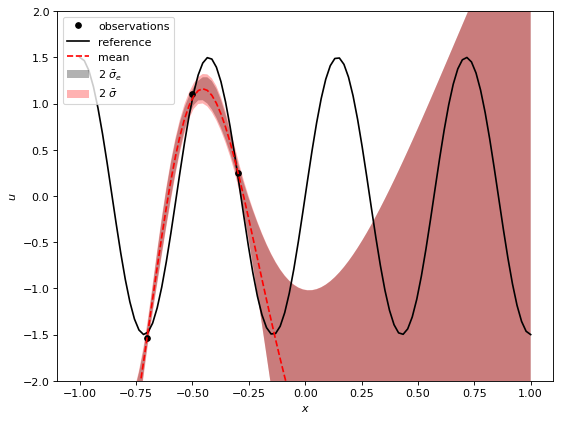

In [7]:
u_pred, = model.predict(x_test, samples, [process_nn])
plot(u_pred[..., 0], ylim=[-2, 2])

# sio.savemat(
#     "sine_NN.mat", 
#     {
#         "x_train": x_train, "u_train": u_train,
#         "x_test": x_test, "u_test": u_test,
#         "u_pred": u_pred, "noise": noise,
#     },
# )

#### Surrogate is a learned GAN (we refer to this model as GAN-FP):
we learn it from historical data

In [8]:
branch = neuq.utils.load_network(
    file_name="../../dataset/pretrained_model/sine/branch.npy", activation=tf.tanh, resnet=True
)
trunk = neuq.utils.load_network(
    file_name="../../dataset/pretrained_model/sine/trunk.npy", activation=tf.tanh, resnet=False
)
surrogate = neuq.surrogates.Generator(
    branch=branch, trunk=trunk, variable_shape=[10],
)
prior = neuq.variables.const.Samplable(mean=0, sigma=1, shape=[10])
process_fp = neuq.process.Process(
    surrogate=surrogate, prior=prior,
)
model = make_model(process_fp)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method



In [9]:
samples, results = model.run()
np.mean(results)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...



0.528

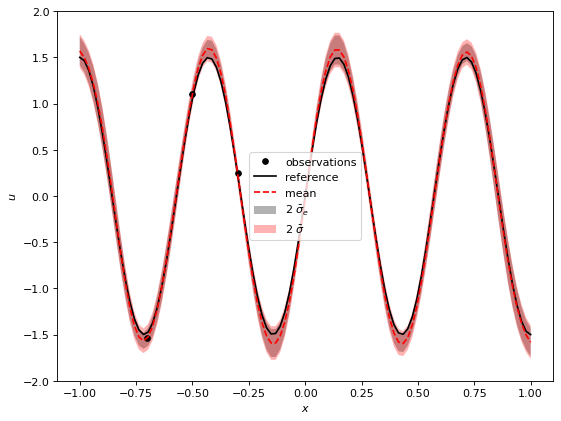

In [10]:
u_pred, = model.predict(x_test, samples, [process_fp])
plot(u_pred[..., 0], ylim=[-2, 2])

# sio.savemat(
#     "sine_FP.mat", 
#     {
#         "x_train": x_train, "u_train": u_train,
#         "x_test": x_test, "u_test": u_test,
#         "u_pred": u_pred, "noise": noise,
#     },
# )

#### Surrogate is an exact one:
we know it is $A\sin(\omega x)$, where $A$ and $\omega$ are unknowns.

Here, enough prior information, e.g. positivity, is needed for $A$ and $\omega$. The references for $A$ and $\omega$ are $1.5$ and $11$, respectively.

In [11]:
def surrogate(inputs, var_list):   
    A, w = tf.exp(var_list[0]), tf.exp(var_list[1])
    return inputs, A * tf.math.sin(w*inputs)

prior_logA = neuq.variables.const.Samplable(
    mean=0, sigma=1, shape=[1],
    initializer=tf.keras.initializers.constant(0.0),
)
# results are sensitive to the initial values of omega
prior_logw = neuq.variables.const.Samplable(
    mean=2, sigma=2, shape=[1],
    initializer=tf.keras.initializers.constant(2.2),
)
process_exact = neuq.process.Process(
    surrogate=surrogate, prior=prior_logA + prior_logw,
)
model = make_model(process_exact)

Supporting backend tensorflow.compat.v1

Compiling a MCMC method



In [12]:
samples, results = model.run()
np.mean(results)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...



0.632

(1000, 1)
Mean of A:  1.5589097 , std of A:  0.04125773
Mean of w:  10.995778 , std of w:  0.069838725


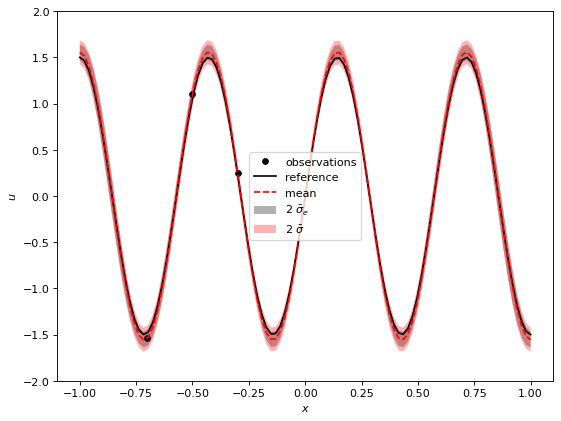

In [13]:
print(samples[0].shape)
As, ws = np.exp(samples[0]), np.exp(samples[1])
print("Mean of A: ", np.mean(As), ", std of A: ", np.std(As))
print("Mean of w: ", np.mean(ws), ", std of w: ", np.std(ws))
u_pred = np.zeros([As.shape[0], x_test.shape[0]])
# postprocessing could be done more efficiently by matrix
# multiplication, instead of for-loop. However, for demonstration,
# we don't do that here.
for i in range(As.shape[0]):
    u_pred[i, :] = As[i] * np.sin(ws[i]*x_test.T) # transpose x_test
plot(u_pred)

# sio.savemat(
#     "sine_exact.mat", 
#     {
#         "x_train": x_train, "u_train": u_train,
#         "x_test": x_test, "u_test": u_test,
#         "u_pred": u_pred, "noise": noise,
#         "A_pred": As, "w_pred": ws,
#     },
# )

#### Calibration for NN surrogate

In [14]:
layers = [1, 50, 1]
process_nn = neuq.process.Process(
    surrogate=neuq.surrogates.FNN(layers=layers),
    prior=neuq.variables.fnn.Samplable(layers=layers, mean=0, sigma=1),
)
model = make_model(process_nn)
samples, results = model.run()
print(np.mean(results))

Supporting backend tensorflow.compat.v1

Compiling a MCMC method

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

0.526


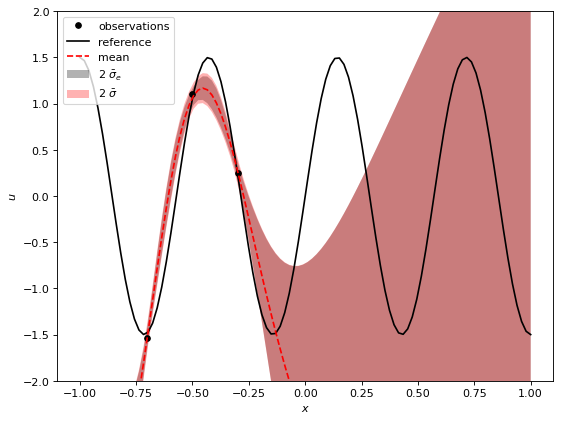

In [15]:
u_pred, = model.predict(x_test, samples, [process_nn])
plot(u_pred[..., 0], ylim=[-2, 2])

In [16]:
u_pred, = model.predict(
    x_cal.reshape([-1, 1]), samples, [process_nn]
)

calibration_model = neuq.calibrations.CalibrationVar(
    targets=tf.constant(u_cal, tf.float32),
    predictions=tf.reduce_mean(u_pred, axis=0),
    stds=tf.math.reduce_std(u_pred, axis=0),
    optimizer=tf.train.AdamOptimizer(1e-3),
)

s = calibration_model.calibrate(num_iterations=20000, sess=model.sess, display_every=2000)

Iteration:  0 , loss:  187.96983
Iteration:  2000 , loss:  13.704849
Iteration:  4000 , loss:  6.593019
Iteration:  6000 , loss:  6.319895
Iteration:  8000 , loss:  6.3194947
Iteration:  10000 , loss:  6.3194947
Iteration:  12000 , loss:  6.3194947
Iteration:  14000 , loss:  6.3194942
Iteration:  16000 , loss:  6.3194947
Iteration:  18000 , loss:  6.3194942


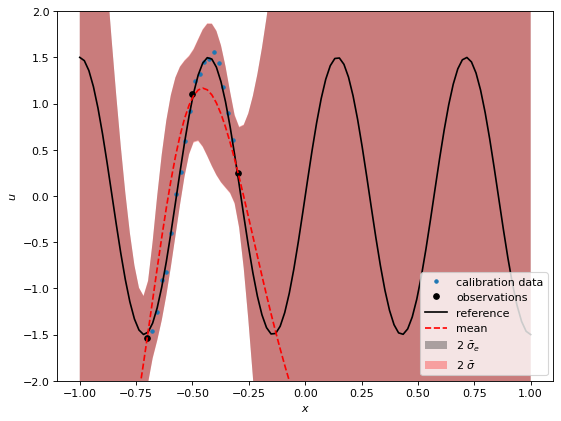

In [17]:
u_pred, = model.predict(x_test, samples, [process_nn])
mu = np.mean(u_pred, axis=0)
std = np.std(u_pred, axis=0) * s

plt.figure(figsize=(8, 6), dpi=80)
plt.plot(x_cal, u_cal, '.', label="calibration data")
plt.plot(x_train, u_train, "k.", markersize=10, label="observations")
plt.plot(x_test, u_test, "k-", label="reference")
plt.plot(x_test, mu, "r--", label="mean")
plt.fill_between(
    x_test.flatten(),
    (mu + 2 * std).flatten(),
    (mu - 2 * std).flatten(),
    alpha=0.3,
    facecolor="k",
    label="2 $\\bar{\\sigma}_e$",
)
plt.fill_between(
    x_test.flatten(),
    (mu + 2 * np.sqrt(std**2 + noise**2)).flatten(),
    (mu - 2 * np.sqrt(std**2 + noise**2)).flatten(),
    alpha=0.3,
    facecolor="r",
    label="2 $\\bar{\\sigma}$",
)
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$u$")
plt.ylim([-2, 2])
plt.show()